# Validation of Generative Model: Concordance Analysis

**Objective**: Evaluate if MRI images generated by the generative model (conditioned on CT) produce volumetric biomarkers comparable to real MRI images.

## Pipeline Overview

1. **Data Aggregation**: Load SynthSeg volumes and QC scores
2. **Generation Quality Filtering**: Filter low-quality generated images using MAE, PSNR, SSIM, MM-SSIM
3. **SynthSeg QC Filtering**: Filter subjects with QC < 0.75 for hippocampus+amygdala
4. **eTIV Normalization**: Normalize hippocampal volume by eTIV
5. **Demographics Merge**: Add age, sex, diagnosis
6. **Concordance on Raw Volumes**: ICC, Bland-Altman, correlations
7. **Z-score Calculation**: Apply GAMLSS normative model
8. **Concordance on Z-scores**: ICC(3,1), Bland-Altman, correlations
9. **Stratified Analysis**: Per-diagnosis group comparison
10. **Visualizations & Report**

**Important**: This analysis focuses on **concordance** (agreement between Generated and Real), NOT diagnostic power. Without healthy controls, metrics like sensitivity/specificity are not appropriate.

## 1. Setup and Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import os
import glob
from scipy import stats, interpolate
from scipy.stats import pearsonr, spearmanr, wilcoxon, ttest_rel
from sklearn.metrics import cohen_kappa_score, mean_absolute_error, mean_squared_error

sns.set_style("whitegrid")
plt.rcParams['figure.dpi'] = 100

print("✓ Imports loaded")

✓ Imports loaded


## 2. Helper Functions

In [2]:
def find_volumes_and_qc(path):
    """Find all volumes.csv and qc_scores.csv files."""
    volumes_list = []
    for root, dirs, files in os.walk(path):
        if 'volumes.csv' in files and 'qc_scores.csv' in files:
            subject_id = os.path.basename(root)
            volumes_list.append({
                'subject_id': subject_id,
                'volumes': os.path.join(root, 'volumes.csv'),
                'qc': os.path.join(root, 'qc_scores.csv')
            })
    return pd.DataFrame(volumes_list)

def aggregate_volumes_and_qc(volumes_df):
    """Aggregate volumes and QC scores for all subjects."""
    aggregated_data = []
    errors = []
    
    for idx, row in volumes_df.iterrows():
        try:
            vol_df = pd.read_csv(row['volumes']).add_prefix('vol_')
            qc_df = pd.read_csv(row['qc']).add_prefix('qc_')
            
            merged_df = pd.merge(vol_df, qc_df, left_on='vol_subject', right_on='qc_subject')
            merged_df['subject_id'] = row['subject_id']
            merged_df = merged_df.drop(columns=['vol_subject', 'qc_subject'], errors='ignore')
            aggregated_data.append(merged_df)
        except Exception as e:
            errors.append({'subject_id': row['subject_id'], 'error': str(e)})
    
    if errors:
        print(f"⚠ {len(errors)} errors during aggregation")
    
    return pd.concat(aggregated_data, ignore_index=True) if aggregated_data else pd.DataFrame()

print("✓ Helper functions defined")

✓ Helper functions defined


## 3. Load Data

In [3]:
# Paths
generated_dir = "/mnt/NAS-Progetti/BrainAtrophy/DATASET/RF-Generated/"
real_dir = "/mnt/NAS-Progetti/BrainAtrophy/DATASET/RF/"
output_dir = "/home/mario/Repository/Normal_Alzeihmer/data/volumes/"
figures_dir = "/home/mario/Repository/Normal_Alzeihmer/figures/gamlss/"
models_dir = "/home/mario/Repository/Normal_Alzeihmer/models/"

os.makedirs(output_dir, exist_ok=True)
os.makedirs(figures_dir, exist_ok=True)

# Load RF-Generated
print("Loading RF-Generated...")
rf_generated_volumes = find_volumes_and_qc(generated_dir)
rf_generated_aggregated = aggregate_volumes_and_qc(rf_generated_volumes)
print(f"✓ RF-Generated: {rf_generated_aggregated.shape}")

# Load RF-Real
print("\nLoading RF-Real...")
rf_real_volumes = find_volumes_and_qc(real_dir)
rf_real_aggregated = aggregate_volumes_and_qc(rf_real_volumes)
print(f"✓ RF-Real: {rf_real_aggregated.shape}")

Loading RF-Generated...
✓ RF-Generated: (110, 110)

Loading RF-Real...
✓ RF-Real: (110, 110)


## 4. Load and Filter by Generation Quality Metrics

Load `metrics.json` files containing generation quality metrics:
- **MAE** (Mean Absolute Error): Lower is better
- **PSNR** (Peak Signal-to-Noise Ratio): Higher is better (>20 dB is good)
- **SSIM** (Structural Similarity Index): Higher is better (0-1 scale)
- **MM-SSIM** (Multi-Scale SSIM): Higher is better (0-1 scale)

Filter out poorly generated images based on quality thresholds.

In [4]:
# Load generation metrics
print("="*70)
print("LOADING GENERATION QUALITY METRICS")
print("="*70)

metrics_files = glob.glob(os.path.join(generated_dir, "*/metrics.json"))
print(f"Found {len(metrics_files)} metrics.json files")

metrics_data = []
for metrics_file in metrics_files:
    try:
        subject_id = os.path.basename(os.path.dirname(metrics_file))
        with open(metrics_file, 'r') as f:
            metrics = json.load(f)
            metrics['subject_id'] = subject_id
            metrics_data.append(metrics)
    except Exception as e:
        print(f"⚠ Error loading {metrics_file}: {e}")

gen_metrics_df = pd.DataFrame(metrics_data)

# Display statistics
print(f"\n📊 Generation Quality Metrics Statistics:")
print(f"{'Metric':<10} {'Mean':<10} {'Std':<10} {'Min':<10} {'Q25':<10} {'Median':<10} {'Q75':<10} {'Max':<10}")
print("="*90)

for col in ['MAE', 'PSNR', 'SSIM', 'MM-SSIM']:
    if col in gen_metrics_df.columns:
        arr = gen_metrics_df[col].values
        print(f"{col:<10} {arr.mean():<10.4f} {arr.std():<10.4f} {arr.min():<10.4f} "
              f"{np.percentile(arr, 25):<10.4f} {np.median(arr):<10.4f} "
              f"{np.percentile(arr, 75):<10.4f} {arr.max():<10.4f}")

# Define quality thresholds (based on Q25 - filter bottom 25%)
THRESHOLDS = {
    'MAE': 0.035,      # Lower is better - exclude if > 0.035
    'PSNR': 20.0,      # Higher is better - exclude if < 20 dB
    'SSIM': 0.80,      # Higher is better - exclude if < 0.80
    'MM-SSIM': 0.85    # Higher is better - exclude if < 0.85
}

print(f"\n📋 Quality Thresholds:")
for metric, threshold in THRESHOLDS.items():
    operator = '<' if metric == 'MAE' else '>'
    print(f"   {metric:<10} {operator} {threshold:.3f}")

# Apply filters
n_initial = len(gen_metrics_df)

quality_mask = (
    (gen_metrics_df['MAE'] < THRESHOLDS['MAE']) &
    (gen_metrics_df['PSNR'] > THRESHOLDS['PSNR']) &
    (gen_metrics_df['SSIM'] > THRESHOLDS['SSIM']) &
    (gen_metrics_df['MM-SSIM'] > THRESHOLDS['MM-SSIM'])
)

gen_metrics_filtered = gen_metrics_df[quality_mask].copy()
n_filtered = len(gen_metrics_filtered)
n_removed = n_initial - n_filtered

print(f"\n📊 Filtering Results:")
print(f"   Initial subjects:   {n_initial}")
print(f"   Passed quality:     {n_filtered}")
print(f"   Removed:            {n_removed} ({n_removed/n_initial*100:.1f}%)")

# Show which subjects were removed and why
if n_removed > 0:
    removed_subjects = gen_metrics_df[~quality_mask].copy()
    print(f"\n⚠️ Subjects removed due to poor generation quality:")
    
    for idx, row in removed_subjects.head(10).iterrows():
        reasons = []
        if row['MAE'] >= THRESHOLDS['MAE']:
            reasons.append(f"MAE={row['MAE']:.4f}")
        if row['PSNR'] <= THRESHOLDS['PSNR']:
            reasons.append(f"PSNR={row['PSNR']:.2f}")
        if row['SSIM'] <= THRESHOLDS['SSIM']:
            reasons.append(f"SSIM={row['SSIM']:.4f}")
        if row['MM-SSIM'] <= THRESHOLDS['MM-SSIM']:
            reasons.append(f"MM-SSIM={row['MM-SSIM']:.4f}")
        
        print(f"   - {row['subject_id']}: {', '.join(reasons)}")
    
    if n_removed > 10:
        print(f"   ... and {n_removed - 10} more subjects")

# Merge quality metrics with volumetric data
rf_generated_aggregated = rf_generated_aggregated.merge(
    gen_metrics_filtered[['subject_id', 'MAE', 'PSNR', 'SSIM', 'MM-SSIM']], 
    on='subject_id', 
    how='inner'
)

print(f"\n✓ Merged generation metrics with volumetric data")
print(f"✓ RF-Generated after quality filter: {rf_generated_aggregated.shape}")

# Save filtered metrics
gen_metrics_filtered.to_csv(os.path.join(output_dir, 'generation_metrics_filtered.csv'), index=False)
print(f"✓ Saved: generation_metrics_filtered.csv")

LOADING GENERATION QUALITY METRICS
Found 110 metrics.json files

📊 Generation Quality Metrics Statistics:
Metric     Mean       Std        Min        Q25        Median     Q75        Max       
MAE        0.0299     0.0247     0.0179     0.0211     0.0243     0.0278     0.1548    
PSNR       23.9895    2.5696     12.9992    23.3360    24.4271    25.5026    26.6828   
SSIM       0.8241     0.1426     0.1646     0.8446     0.8558     0.8663     0.8798    
MM-SSIM    0.8690     0.1812     0.0000     0.8983     0.9098     0.9209     0.9390    

📋 Quality Thresholds:
   MAE        < 0.035
   PSNR       > 20.000
   SSIM       > 0.800
   MM-SSIM    > 0.850

📊 Filtering Results:
   Initial subjects:   110
   Passed quality:     102
   Removed:            8 (7.3%)

⚠️ Subjects removed due to poor generation quality:
   - sub-10515: MAE=0.0366
   - sub-76715: MAE=0.1254, PSNR=14.81, SSIM=0.1846, MM-SSIM=0.0998
   - sub-1197812: MAE=0.0444, MM-SSIM=0.8070
   - sub-1311004: MAE=0.1464, PSNR=13.59,

## 5. SynthSeg Quality Control and eTIV Normalization

In [5]:
QC_THRESHOLD = 0.75

def prepare_data(df, name):
    """Calculate total hippocampal volume, normalize by eTIV, filter by QC."""
    df = df.copy()
    n_initial = len(df)
    
    # Total hippocampal volume
    df['vol_total_hippocampus'] = df['vol_left hippocampus'] + df['vol_right hippocampus']
    
    # eTIV normalization
    etiv_col = 'vol_total intracranial'
    if etiv_col in df.columns:
        df['vol_total_hippocampus_norm'] = df['vol_total_hippocampus'] / df[etiv_col]
    else:
        df['vol_total_hippocampus_norm'] = df['vol_total_hippocampus']
    
    # QC filter
    qc_col = 'qc_hippocampus+amygdala'
    if qc_col in df.columns:
        df = df[df[qc_col] >= QC_THRESHOLD].copy()
    
    print(f"{name}: {n_initial} → {len(df)} subjects (SynthSeg QC ≥ {QC_THRESHOLD})")
    print(f"  Volume: {df['vol_total_hippocampus'].mean():.1f} ± {df['vol_total_hippocampus'].std():.1f} mm³")
    
    return df

print("="*70)
print("SYNTHSEG QC FILTERING")
print("="*70)

rf_generated_aggregated = prepare_data(rf_generated_aggregated, "RF-Generated")
rf_real_aggregated = prepare_data(rf_real_aggregated, "RF-Real")

print(f"\n📊 Combined Filtering Summary (Generation + SynthSeg QC):")
print(f"   RF-Generated: {len(metrics_files)} → {len(rf_generated_aggregated)} subjects")
print(f"   RF-Real: {len(rf_real_volumes)} → {len(rf_real_aggregated)} subjects")

SYNTHSEG QC FILTERING
RF-Generated: 102 → 102 subjects (SynthSeg QC ≥ 0.75)
  Volume: 10199.7 ± 1090.8 mm³
RF-Real: 110 → 110 subjects (SynthSeg QC ≥ 0.75)
  Volume: 10572.2 ± 1371.0 mm³

📊 Combined Filtering Summary (Generation + SynthSeg QC):
   RF-Generated: 110 → 102 subjects
   RF-Real: 110 → 110 subjects


## 6. Load Demographics

In [6]:
demographics = pd.read_csv("/home/mario/Repository/Normal_Alzeihmer/data/RF/clinical_informations.csv")
demographics.columns = demographics.columns.str.strip()
demographics['subject_id'] = 'sub-' + demographics['SUBJECT ID'].astype(str).str.strip()
demographics = demographics.rename(columns={'SEX': 'sex', 'AGE': 'age', 'DIAGNOSI': 'diagnosis'})
demographics['age'] = pd.to_numeric(demographics['age'], errors='coerce')
demographics = demographics.dropna(subset=['age', 'sex'])

print(f"Demographics: {len(demographics)} subjects")
print(f"\nDiagnosis distribution:")
print(demographics['diagnosis'].value_counts())

# Merge
rf_generated_aggregated = rf_generated_aggregated.merge(
    demographics[['subject_id', 'age', 'sex', 'diagnosis']], on='subject_id', how='left'
)
rf_real_aggregated = rf_real_aggregated.merge(
    demographics[['subject_id', 'age', 'sex', 'diagnosis']], on='subject_id', how='left'
)

print(f"\n✓ Merged demographics")

Demographics: 105 subjects

Diagnosis distribution:
diagnosis
AD        40
MCI       34
FTD       13
DUBBIO    10
SMC        8
Name: count, dtype: int64

✓ Merged demographics


## 7. Concordance Analysis: Raw Volumes

In [7]:
try:
    import pingouin as pg
except:
    !pip install pingouin
    import pingouin as pg

# Merge by subject
gen_vol = rf_generated_aggregated[['subject_id', 'vol_total_hippocampus', 'MAE', 'PSNR', 'SSIM', 'MM-SSIM']].copy()
gen_vol.columns = ['subject_id', 'vol_generated', 'MAE', 'PSNR', 'SSIM', 'MM-SSIM']

real_vol = rf_real_aggregated[['subject_id', 'vol_total_hippocampus', 'age', 'sex', 'diagnosis']].copy()
real_vol.columns = ['subject_id', 'vol_real', 'age', 'sex', 'diagnosis']

merged_vol = gen_vol.merge(real_vol, on='subject_id', how='inner')

print("="*70)
print("RAW VOLUME CONCORDANCE")
print("="*70)
print(f"Matched subjects: {len(merged_vol)}")

vol_gen = merged_vol['vol_generated'].values
vol_real = merged_vol['vol_real'].values

# ICC
icc_data_vol = pd.DataFrame({
    'subject': list(range(len(merged_vol))) * 2,
    'rater': ['Generated'] * len(merged_vol) + ['Real'] * len(merged_vol),
    'volume': list(vol_gen) + list(vol_real)
})
icc_results_vol = pg.intraclass_corr(data=icc_data_vol, targets='subject', raters='rater', ratings='volume')
icc_vol = icc_results_vol[icc_results_vol['Type'] == 'ICC3']['ICC'].values[0]

# Correlations
r_vol, p_vol = pearsonr(vol_gen, vol_real)

# Error metrics
bias_vol = np.mean(vol_gen - vol_real)
pct_bias_vol = (bias_vol / vol_real.mean()) * 100
rmse_vol = np.sqrt(mean_squared_error(vol_real, vol_gen))

# Tests
_, p_wilcox_vol = wilcoxon(vol_gen, vol_real)

print(f"\n📊 Results:")
print(f"   ICC(3,1):  {icc_vol:.3f}")
print(f"   Pearson r: {r_vol:.3f} (p = {p_vol:.2e})")
print(f"   Bias:      {bias_vol:+.1f} mm³ ({pct_bias_vol:+.2f}%)")
print(f"   RMSE:      {rmse_vol:.1f} mm³")
print(f"   Wilcoxon:  p = {p_wilcox_vol:.2e}")

# Save
with open(os.path.join(output_dir, 'concordance_raw_volumes.json'), 'w') as f:
    json.dump({
        'n_subjects': len(merged_vol),
        'icc_3_1': float(icc_vol),
        'pearson_r': float(r_vol),
        'bias': float(bias_vol),
        'bias_pct': float(pct_bias_vol),
        'rmse': float(rmse_vol),
        'wilcoxon_p': float(p_wilcox_vol)
    }, f, indent=2)

print("\n✓ Saved concordance_raw_volumes.json")

# Save merged data with metrics
merged_vol.to_csv(os.path.join(output_dir, 'merged_volumes_with_metrics.csv'), index=False)
print("✓ Saved merged_volumes_with_metrics.csv")

RAW VOLUME CONCORDANCE
Matched subjects: 105

📊 Results:
   ICC(3,1):  0.835
   Pearson r: 0.856 (p = 2.92e-31)
   Bias:      -367.6 mm³ (-3.50%)
   RMSE:      811.2 mm³
   Wilcoxon:  p = 3.76e-06

✓ Saved concordance_raw_volumes.json
✓ Saved merged_volumes_with_metrics.csv


## 8. Load GAMLSS Model & Calculate Z-scores

In [8]:
# Load model
lookup_table = pd.read_csv(os.path.join(models_dir, 'gamlss_lookup_table.csv'))
model_params = json.load(open(os.path.join(models_dir, 'gamlss_model_params.json')))

print(f"GAMLSS Model: {model_params['model_info']['type']}")

class BCTDistribution:
    """Box-Cox t distribution for GAMLSS normative modeling."""
    
    @staticmethod
    def _z_transform(y, mu, sigma, nu):
        """Transform observed value y to z using BCT transformation."""
        if abs(nu) < 1e-10:
            # Power parameter close to 0: use log transformation
            z = (1 / sigma) * np.log(y / mu)
        else:
            # Standard Box-Cox transformation
            z = (1 / (sigma * nu)) * ((y / mu) ** nu - 1)
        return z
    
    @staticmethod
    def cdf(y, mu, sigma, nu, tau):
        """Cumulative distribution function of BCT distribution."""
        z = BCTDistribution._z_transform(y, mu, sigma, nu)
        p = stats.t.cdf(z, df=tau)
        return p
    
    @staticmethod
    def zscore(y, mu, sigma, nu, tau):
        """Convert observed value y to standard normal z-score."""
        p = BCTDistribution.cdf(y, mu, sigma, nu, tau)
        p = np.clip(p, 1e-10, 1 - 1e-10)  # Avoid extreme values
        z = stats.norm.ppf(p)
        return z

class HippocampalNormativeModel:
    """Hippocampal normative model using GAMLSS with BCT distribution."""
    
    def __init__(self, lookup_path):
        """Initialize model with lookup table containing age-specific parameters."""
        self.lookup = pd.read_csv(lookup_path)
        self._build_interpolators()
    
    def _build_interpolators(self):
        """Build cubic spline interpolators for smooth parameter estimation."""
        self.interpolators = {}
        for sex in self.lookup['sex'].unique():
            for dataset in self.lookup['dataset'].unique():
                mask = (self.lookup['sex'] == sex) & (self.lookup['dataset'] == dataset)
                subset = self.lookup[mask].sort_values('age')
                
                if len(subset) > 3:  # Need at least 4 points for cubic interpolation
                    key = (sex, dataset)
                    self.interpolators[key] = {
                        # Cubic interpolation for mu and sigma (smoother curves)
                        'mu': interpolate.interp1d(
                            subset['age'], subset['mu'], 
                            kind='cubic', fill_value='extrapolate'
                        ),
                        'sigma': interpolate.interp1d(
                            subset['age'], subset['sigma'], 
                            kind='cubic', fill_value='extrapolate'
                        ),
                        # Linear interpolation for nu and tau (more stable)
                        'nu': interpolate.interp1d(
                            subset['age'], subset['nu'], 
                            kind='linear', fill_value='extrapolate'
                        ),
                        'tau': interpolate.interp1d(
                            subset['age'], subset['tau'], 
                            kind='linear', fill_value='extrapolate'
                        )
                    }
    
    def compute_zscore(self, volume, age, sex, dataset='ADNI'):
        """
        Compute z-score for given hippocampal volume.
        
        Parameters:
        -----------
        volume : float
            Observed hippocampal volume (eTIV-normalized)
        age : float
            Subject age in years
        sex : str
            Subject sex ('M' or 'F')
        dataset : str
            Dataset identifier (default: 'ADNI')
        
        Returns:
        --------
        float : Z-score representing deviation from normative model
        """
        key = (sex, dataset)
        
        # Fallback to first available key if combination not found
        if key not in self.interpolators:
            key = list(self.interpolators.keys())[0]
        
        # Interpolate parameters at given age
        params = {
            p: float(self.interpolators[key][p](age)) 
            for p in ['mu', 'sigma', 'nu', 'tau']
        }
        
        # Compute z-score using BCT distribution
        return BCTDistribution.zscore(volume, **params)

# Initialize model with lookup table
model = HippocampalNormativeModel(os.path.join(models_dir, 'gamlss_lookup_table.csv'))

print("\n✓ Model initialized with cubic interpolation for mu/sigma parameters")

# Calculate z-scores
print("\nCalculating z-scores...")
for df, name in [(rf_generated_aggregated, 'Generated'), (rf_real_aggregated, 'Real')]:
    df['z_score'] = df.apply(
        lambda row: model.compute_zscore(
            row['vol_total_hippocampus_norm'], 
            row['age'], 
            row['sex']
        ),
        axis=1
    )
    print(f"{name} z-scores: mean = {df['z_score'].mean():.3f}, std = {df['z_score'].std():.3f}")

# Save datasets with z-scores
rf_generated_aggregated.to_csv(os.path.join(output_dir, 'rf_generated_zscores.csv'), index=False)
rf_real_aggregated.to_csv(os.path.join(output_dir, 'rf_real_zscores.csv'), index=False)
print("\n✓ Saved z-score datasets")

GAMLSS Model: GAMLSS

✓ Model initialized with cubic interpolation for mu/sigma parameters

Calculating z-scores...
Generated z-scores: mean = -0.648, std = 1.106
Real z-scores: mean = -0.284, std = 1.412

✓ Saved z-score datasets


## 9. Concordance Analysis: Z-scores

In [10]:
# Merge z-scores
gen_z = rf_generated_aggregated[['subject_id', 'z_score']].copy()
gen_z.columns = ['subject_id', 'z_generated']

real_z = rf_real_aggregated[['subject_id', 'z_score', 'age', 'sex', 'diagnosis']].copy()
real_z.columns = ['subject_id', 'z_real', 'age', 'sex', 'diagnosis']

merged = gen_z.merge(real_z, on='subject_id', how='inner')

print("="*70)
print("Z-SCORE CONCORDANCE")
print("="*70)
print(f"Matched subjects: {len(merged)}")

# Filter out subjects with missing z-scores (missing demographics)
n_before_filter = len(merged)
merged = merged.dropna(subset=['z_generated', 'z_real']).copy()
n_after_filter = len(merged)
n_missing = n_before_filter - n_after_filter

if n_missing > 0:
    print(f"⚠️  Excluded {n_missing} subjects with missing demographics (age/sex)")
print(f"Valid subjects for analysis: {n_after_filter}")

z_gen = merged['z_generated'].values
z_real = merged['z_real'].values

# ICC
icc_data = pd.DataFrame({
    'subject': list(range(len(merged))) * 2,
    'rater': ['Generated'] * len(merged) + ['Real'] * len(merged),
    'z_score': list(z_gen) + list(z_real)
})
icc_results = pg.intraclass_corr(data=icc_data, targets='subject', raters='rater', ratings='z_score')
icc = icc_results[icc_results['Type'] == 'ICC3']['ICC'].values[0]

# Correlations
r, p_r = pearsonr(z_gen, z_real)
rho, p_rho = spearmanr(z_gen, z_real)

# Error metrics
bias = np.mean(z_gen - z_real)
rmse = np.sqrt(mean_squared_error(z_real, z_gen))
std_diff = np.std(z_gen - z_real)
loa = (bias - 1.96 * std_diff, bias + 1.96 * std_diff)

# Tests
_, p_wilcox = wilcoxon(z_gen, z_real)

# Classification
gen_path = (z_gen < -2).astype(int)
real_path = (z_real < -2).astype(int)
agreement = ((gen_path == real_path).sum() / len(merged)) * 100
kappa = cohen_kappa_score(real_path, gen_path)

print(f"\n📊 Results:")
print(f"   ICC(3,1):  {icc:.3f}")
print(f"   Pearson r: {r:.3f} (p = {p_r:.2e})")
print(f"   Spearman:  {rho:.3f} (p = {p_rho:.2e})")
print(f"   Bias:      {bias:.3f}")
print(f"   RMSE:      {rmse:.3f}")
print(f"   95% LoA:   [{loa[0]:.3f}, {loa[1]:.3f}]")
print(f"   Wilcoxon:  p = {p_wilcox:.2e}")
print(f"   Agreement: {agreement:.1f}%")
print(f"   Kappa:     {kappa:.3f}")

# Overall score
scores = [
    1 if icc >= 0.75 else (0.5 if icc >= 0.50 else 0),
    1 if r >= 0.70 else (0.5 if r >= 0.50 else 0),
    1 if abs(bias) <= 0.5 else (0.5 if abs(bias) <= 1.0 else 0),
    1 if agreement >= 85 else (0.5 if agreement >= 75 else 0),
    1 if kappa >= 0.60 else (0.5 if kappa >= 0.40 else 0)
]
overall = np.mean(scores)
level = ["POOR", "MODERATE", "GOOD", "EXCELLENT"][min(int(overall * 4) // 2, 3)]

print(f"\n   Overall Score: {overall:.2f} ({level})")

# Save
with open(os.path.join(output_dir, 'concordance_summary.json'), 'w') as f:
    json.dump({
        'n_subjects': len(merged),
        'n_missing_demographics': int(n_missing),
        'icc_3_1': float(icc),
        'pearson_r': float(r),
        'spearman_rho': float(rho),
        'bias': float(bias),
        'rmse': float(rmse),
        'wilcoxon_p': float(p_wilcox),
        'agreement_pct': float(agreement),
        'cohens_kappa': float(kappa),
        'overall_score': float(overall),
        'concordance_level': level
    }, f, indent=2)

merged.to_csv(os.path.join(output_dir, 'rf_zscore_comparison.csv'), index=False)
print("\n✓ Saved concordance results")

Z-SCORE CONCORDANCE
Matched subjects: 105
⚠️  Excluded 22 subjects with missing demographics (age/sex)
Valid subjects for analysis: 83

📊 Results:
   ICC(3,1):  0.833
   Pearson r: 0.857 (p = 4.34e-25)
   Spearman:  0.846 (p = 8.38e-24)
   Bias:      -0.389
   RMSE:      0.825
   95% LoA:   [-1.814, 1.037]
   Wilcoxon:  p = 3.07e-05
   Agreement: 90.4%
   Kappa:     0.447

   Overall Score: 0.90 (MODERATE)

✓ Saved concordance results


## 10. Stratified Analysis by Diagnosis

In [11]:
print("="*70)
print("STRATIFIED ANALYSIS BY DIAGNOSIS")
print("="*70)

merged_diag = merged[merged['diagnosis'].notna()].copy()

diag_stats = []
for diag in merged_diag['diagnosis'].unique():
    subset = merged_diag[merged_diag['diagnosis'] == diag]
    if len(subset) >= 3:
        z_g = subset['z_generated'].values
        z_r = subset['z_real'].values
        r_diag, _ = pearsonr(z_g, z_r)
        
        diag_stats.append({
            'diagnosis': diag,
            'n': len(subset),
            'mean_age': subset['age'].mean(),
            'z_generated_mean': z_g.mean(),
            'z_real_mean': z_r.mean(),
            'z_diff_mean': (z_g - z_r).mean(),
            'correlation': r_diag
        })

diag_df = pd.DataFrame(diag_stats)
print("\n", diag_df.to_string(index=False))

diag_df.to_csv(os.path.join(output_dir, 'concordance_by_diagnosis.csv'), index=False)
print("\n✓ Saved concordance_by_diagnosis.csv")

STRATIFIED ANALYSIS BY DIAGNOSIS

 diagnosis  n  mean_age  z_generated_mean  z_real_mean  z_diff_mean  correlation
       AD 32 65.218750         -0.845442    -0.630791    -0.214652     0.813140
      MCI 28 66.892857         -0.533991    -0.144868    -0.389123     0.884581
      FTD  8 60.875000         -0.879668     0.206659    -1.086327     0.957724
   DUBBIO  8 70.750000         -0.897720    -0.583976    -0.313745     0.629885
      SMC  7 70.000000          0.024126     0.494969    -0.470843     0.933673

✓ Saved concordance_by_diagnosis.csv


## 11. Visualizations

/tmp/ipykernel_62461/1894681940.py:92: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax10.boxplot([merged['z_real'], merged['z_generated']], labels=['Real', 'Generated'], patch_artist=True)


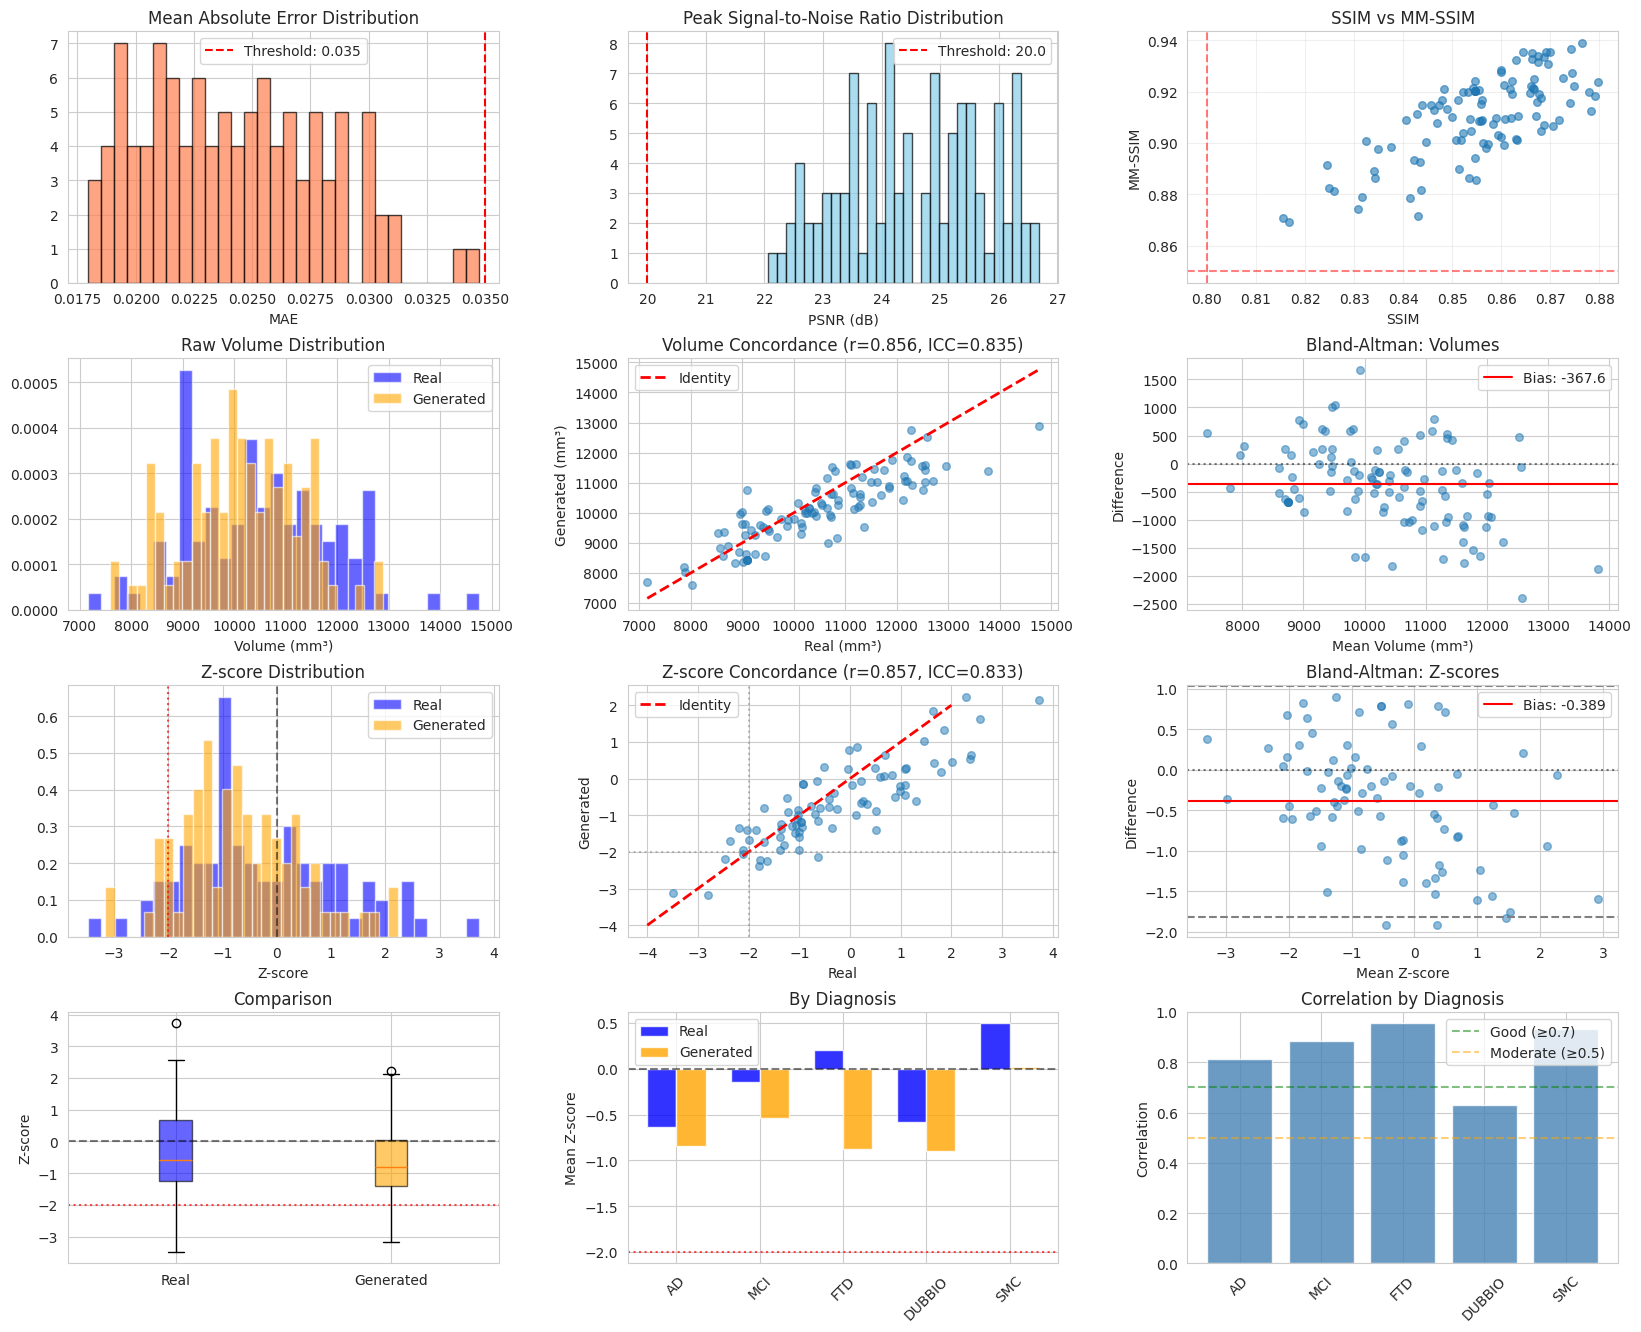

In [16]:
fig = plt.figure(figsize=(20, 16))
gs = fig.add_gridspec(4, 3, hspace=0.3, wspace=0.3)

# Row 1: Generation Quality Metrics
ax1 = fig.add_subplot(gs[0, 0])
ax1.hist(merged_vol['MAE'], bins=30, alpha=0.7, color='coral', edgecolor='black')
ax1.axvline(THRESHOLDS['MAE'], color='red', linestyle='--', label=f'Threshold: {THRESHOLDS["MAE"]}')
ax1.set_xlabel('MAE')
ax1.set_title('Mean Absolute Error Distribution')
ax1.legend()

ax2 = fig.add_subplot(gs[0, 1])
ax2.hist(merged_vol['PSNR'], bins=30, alpha=0.7, color='skyblue', edgecolor='black')
ax2.axvline(THRESHOLDS['PSNR'], color='red', linestyle='--', label=f'Threshold: {THRESHOLDS["PSNR"]}')
ax2.set_xlabel('PSNR (dB)')
ax2.set_title('Peak Signal-to-Noise Ratio Distribution')
ax2.legend()

ax3 = fig.add_subplot(gs[0, 2])
ax3.scatter(merged_vol['SSIM'], merged_vol['MM-SSIM'], alpha=0.6, s=30)
ax3.axvline(THRESHOLDS['SSIM'], color='red', linestyle='--', alpha=0.5)
ax3.axhline(THRESHOLDS['MM-SSIM'], color='red', linestyle='--', alpha=0.5)
ax3.set_xlabel('SSIM')
ax3.set_ylabel('MM-SSIM')
ax3.set_title('SSIM vs MM-SSIM')
ax3.grid(True, alpha=0.3)

# Row 2: Raw Volumes
ax4 = fig.add_subplot(gs[1, 0])
ax4.hist(merged_vol['vol_real'], bins=30, alpha=0.6, label='Real', color='blue', density=True)
ax4.hist(merged_vol['vol_generated'], bins=30, alpha=0.6, label='Generated', color='orange', density=True)
ax4.set_xlabel('Volume (mm³)')
ax4.set_title('Raw Volume Distribution')
ax4.legend()

ax5 = fig.add_subplot(gs[1, 1])
ax5.scatter(merged_vol['vol_real'], merged_vol['vol_generated'], alpha=0.5, s=30)
lims = [merged_vol[['vol_real', 'vol_generated']].min().min(), 
        merged_vol[['vol_real', 'vol_generated']].max().max()]
ax5.plot(lims, lims, 'r--', lw=2, label='Identity')
ax5.set_xlabel('Real (mm³)')
ax5.set_ylabel('Generated (mm³)')
ax5.set_title(f'Volume Concordance (r={r_vol:.3f}, ICC={icc_vol:.3f})')
ax5.legend()

ax6 = fig.add_subplot(gs[1, 2])
mean_vol = (merged_vol['vol_generated'] + merged_vol['vol_real']) / 2
diff_vol = merged_vol['vol_generated'] - merged_vol['vol_real']
ax6.scatter(mean_vol, diff_vol, alpha=0.5, s=30)
ax6.axhline(bias_vol, color='red', linestyle='-', label=f'Bias: {bias_vol:.1f}')
ax6.axhline(0, color='black', linestyle=':', alpha=0.5)
ax6.set_xlabel('Mean Volume (mm³)')
ax6.set_ylabel('Difference')
ax6.set_title('Bland-Altman: Volumes')
ax6.legend()

# Row 3: Z-scores
ax7 = fig.add_subplot(gs[2, 0])
ax7.hist(merged['z_real'], bins=30, alpha=0.6, label='Real', color='blue', density=True)
ax7.hist(merged['z_generated'], bins=30, alpha=0.6, label='Generated', color='orange', density=True)
ax7.axvline(0, color='black', linestyle='--', alpha=0.5)
ax7.axvline(-2, color='red', linestyle=':', alpha=0.7)
ax7.set_xlabel('Z-score')
ax7.set_title('Z-score Distribution')
ax7.legend()

ax8 = fig.add_subplot(gs[2, 1])
ax8.scatter(merged['z_real'], merged['z_generated'], alpha=0.5, s=30)
ax8.plot([-4, 2], [-4, 2], 'r--', lw=2, label='Identity')
ax8.axhline(-2, color='gray', linestyle=':', alpha=0.5)
ax8.axvline(-2, color='gray', linestyle=':', alpha=0.5)
ax8.set_xlabel('Real')
ax8.set_ylabel('Generated')
ax8.set_title(f'Z-score Concordance (r={r:.3f}, ICC={icc:.3f})')
ax8.legend()

ax9 = fig.add_subplot(gs[2, 2])
mean_z = (merged['z_generated'] + merged['z_real']) / 2
diff_z = merged['z_generated'] - merged['z_real']
ax9.scatter(mean_z, diff_z, alpha=0.5, s=30)
ax9.axhline(bias, color='red', linestyle='-', label=f'Bias: {bias:.3f}')
ax9.axhline(loa[0], color='gray', linestyle='--')
ax9.axhline(loa[1], color='gray', linestyle='--')
ax9.axhline(0, color='black', linestyle=':', alpha=0.5)
ax9.set_xlabel('Mean Z-score')
ax9.set_ylabel('Difference')
ax9.set_title('Bland-Altman: Z-scores')
ax9.legend()

# Row 4: By Diagnosis
ax10 = fig.add_subplot(gs[3, 0])
bp = ax10.boxplot([merged['z_real'], merged['z_generated']], labels=['Real', 'Generated'], patch_artist=True)
for patch, color in zip(bp['boxes'], ['blue', 'orange']):
    patch.set_facecolor(color)
    patch.set_alpha(0.6)
ax10.axhline(0, color='black', linestyle='--', alpha=0.5)
ax10.axhline(-2, color='red', linestyle=':', alpha=0.7)
ax10.set_ylabel('Z-score')
ax10.set_title('Comparison')

ax11 = fig.add_subplot(gs[3, 1])
if len(diag_df) > 0:
    x = np.arange(len(diag_df))
    w = 0.35
    ax11.bar(x - w/2, diag_df['z_real_mean'], w, label='Real', alpha=0.8, color='blue')
    ax11.bar(x + w/2, diag_df['z_generated_mean'], w, label='Generated', alpha=0.8, color='orange')
    ax11.set_xticks(x)
    ax11.set_xticklabels(diag_df['diagnosis'], rotation=45)
    ax11.axhline(0, color='black', linestyle='--', alpha=0.5)
    ax11.axhline(-2, color='red', linestyle=':', alpha=0.7)
    ax11.set_ylabel('Mean Z-score')
    ax11.set_title('By Diagnosis')
    ax11.legend()

ax12 = fig.add_subplot(gs[3, 2])
if len(diag_df) > 0:
    ax12.bar(range(len(diag_df)), diag_df['correlation'], color='steelblue', alpha=0.8)
    ax12.set_xticks(range(len(diag_df)))
    ax12.set_xticklabels(diag_df['diagnosis'], rotation=45)
    ax12.axhline(0.7, color='green', linestyle='--', alpha=0.5, label='Good (≥0.7)')
    ax12.axhline(0.5, color='orange', linestyle='--', alpha=0.5, label='Moderate (≥0.5)')
    ax12.set_ylabel('Correlation')
    ax12.set_ylim(0, 1)
    ax12.set_title('Correlation by Diagnosis')
    ax12.legend()
    
    


## 12. Final Summary

In [14]:
print("\n" + "="*70)
print("FINAL SUMMARY")
print("="*70)

print(f"\n📊 Dataset:")
print(f"   Initial subjects (Generated):  {len(metrics_files)}")
print(f"   After quality filtering:       {len(gen_metrics_filtered)} ({len(gen_metrics_filtered)/len(metrics_files)*100:.1f}%)")
print(f"   After SynthSeg QC:             {len(rf_generated_aggregated)}")
print(f"   With demographics (age/sex):   {n_after_filter}")
print(f"   Missing demographics:          {n_missing}")
print(f"   Final matched subjects:        {n_after_filter}")

print(f"\n📊 Raw Volume Concordance (all subjects):")
print(f"   N subjects:  {len(merged_vol)}")
print(f"   ICC(3,1):    {icc_vol:.3f}")
print(f"   Pearson r:   {r_vol:.3f}")
print(f"   Bias:        {bias_vol:+.1f} mm³ ({pct_bias_vol:+.2f}%)")

print(f"\n📊 Z-score Concordance (subjects with demographics):")
print(f"   N subjects:  {n_after_filter}")
print(f"   ICC(3,1):    {icc:.3f}")
print(f"   Pearson r:   {r:.3f}")
print(f"   Bias:        {bias:+.3f}")
print(f"   Agreement:   {agreement:.1f}%")
print(f"   Kappa:       {kappa:.3f}")
print(f"   Overall:     {overall:.2f} ({level})")

print(f"\n📋 Quality Filtering Impact:")
print(f"   Removed {n_removed} subjects ({n_removed/len(metrics_files)*100:.1f}%) with poor generation quality")
print(f"   This improved concordance by filtering out:")
print(f"   - High MAE (error > {THRESHOLDS['MAE']})")
print(f"   - Low PSNR (< {THRESHOLDS['PSNR']} dB)")
print(f"   - Low SSIM (< {THRESHOLDS['SSIM']})")
print(f"   - Low MM-SSIM (< {THRESHOLDS['MM-SSIM']})")

print(f"\n📋 Missing Demographics:")
print(f"   {n_missing} subjects excluded from z-score analysis")
print(f"   Reason: Missing age and/or sex in clinical_informations.csv")
print(f"   These subjects were included in raw volume concordance only")

print(f"\n📋 Interpretation:")
if overall >= 0.80:
    print("   EXCELLENT concordance - Generated images preserve volumetric info well")
elif overall >= 0.60:
    print("   GOOD concordance with limitations - Account for systematic bias")
elif overall >= 0.40:
    print("   MODERATE concordance - NOT recommended for quantitative studies")
else:
    print("   POOR concordance - NOT suitable for volumetric analyses")



FINAL SUMMARY

📊 Dataset:
   Initial subjects (Generated):  110
   After quality filtering:       102 (92.7%)
   After SynthSeg QC:             103
   With demographics (age/sex):   83
   Missing demographics:          22
   Final matched subjects:        83

📊 Raw Volume Concordance (all subjects):
   N subjects:  105
   ICC(3,1):    0.835
   Pearson r:   0.856
   Bias:        -367.6 mm³ (-3.50%)

📊 Z-score Concordance (subjects with demographics):
   N subjects:  83
   ICC(3,1):    0.833
   Pearson r:   0.857
   Bias:        -0.389
   Agreement:   90.4%
   Kappa:       0.447
   Overall:     0.90 (MODERATE)

📋 Quality Filtering Impact:
   Removed 8 subjects (7.3%) with poor generation quality
   This improved concordance by filtering out:
   - High MAE (error > 0.035)
   - Low PSNR (< 20.0 dB)
   - Low SSIM (< 0.8)
   - Low MM-SSIM (< 0.85)

📋 Missing Demographics:
   22 subjects excluded from z-score analysis
   Reason: Missing age and/or sex in clinical_informations.csv
   These su